In [3]:
pip install fosforml

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()
 
table_name = '"MASTER_DATA"'
 
sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [7]:
df.columns

Index(['PRODUCT_CODE', 'PRODUCT_DESCRIPTION', 'CATEGORY_CODE', 'CATEGORY',
       'MANUFACTURING_LT', 'MFG_COST', 'LABOR_COST', 'PROFIT_MARGIN',
       'CUSTOMER_CODE', 'PRODUCT_ID', 'Production_Cost', 'Profit', 'Sales',
       'SUM_Part_Cost', 'CUSTOMER_NAME', 'CITY', 'STATE_PROVINCE',
       'COUNTRY_CODE', 'TRANSIT_LT', 'ORDER_ID',
       'Fact_Customer_Orders_PRODUCT_ID', 'ORDER_QTY', 'ORDER_DATE',
       'PART_CODE', 'QPA', 'UOM', 'UNIT_PRICE', 'LEAD_TIME_IN_WEEKS', 'MOQ',
       'PROD_LIFE_CYCLE'],
      dtype='object')

In [8]:
data = df[['ORDER_ID','Fact_Customer_Orders_PRODUCT_ID','ORDER_DATE','ORDER_QTY']]

In [9]:
# Convert ORDER_DATE to datetime if it's not already
data['ORDER_DATE'] = pd.to_datetime(data['ORDER_DATE'])

In [10]:
data_grouped = data.groupby(['Fact_Customer_Orders_PRODUCT_ID',data['ORDER_DATE'].dt.to_period('M')]).agg(Total_Order_Qty=('ORDER_QTY','sum')).reset_index()

In [11]:
data_grouped['ORDER_MONTH']=data_grouped['ORDER_DATE'].dt.to_timestamp()

In [12]:
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Fact_Customer_Orders_PRODUCT_ID  2992 non-null   object        
 1   ORDER_DATE                       2992 non-null   period[M]     
 2   Total_Order_Qty                  2992 non-null   int64         
 3   ORDER_MONTH                      2992 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 93.6+ KB


In [14]:
data_grouped = data_grouped[['Fact_Customer_Orders_PRODUCT_ID','ORDER_MONTH','Total_Order_Qty']]

In [16]:
data_grouped

,Fact_Customer_Orders_PRODUCT_ID,ORDER_MONTH,Total_Order_Qty
0,Product_001,2019-01-01,5639200
1,Product_001,2019-02-01,5572700
2,Product_001,2019-03-01,5059700
3,Product_001,2019-04-01,5836800
4,Product_001,2019-05-01,5876700
...,...,...,...
2987,Product_100,2024-04-01,90600
2988,Product_100,2024-05-01,83550
2989,Product_100,2024-06-01,99600
2990,Product_100,2024-07-01,99900


In [18]:
# Create a new column for the numeric representation of the date
data_grouped['date_numeric'] = (data_grouped['ORDER_MONTH'] - data_grouped['ORDER_MONTH'].min()).dt.days

In [19]:
data_grouped

,Fact_Customer_Orders_PRODUCT_ID,ORDER_MONTH,Total_Order_Qty,date_numeric
0,Product_001,2019-01-01,5639200,0
1,Product_001,2019-02-01,5572700,31
2,Product_001,2019-03-01,5059700,59
3,Product_001,2019-04-01,5836800,90
4,Product_001,2019-05-01,5876700,120
...,...,...,...,...
2987,Product_100,2024-04-01,90600,1917
2988,Product_100,2024-05-01,83550,1947
2989,Product_100,2024-06-01,99600,1978
2990,Product_100,2024-07-01,99900,2008


In [20]:
# Split the data into training and testing sets(80% train, 20% test)
X = data_grouped[['date_numeric']]
y = data_grouped['Total_Order_Qty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [23]:
# Calculate evaluation metrics
rse = np.sqrt(np.sum((y_train - y_train_pred) ** 2) / (len(y_train) - 2))
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)

In [24]:
# Print evaluation metrics
print(f'RSE: {rse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RSE: 1212443.7830958199
RMSE: 1211937.0145123042
R²: 0.0007958303572916936


In [25]:
# Forecast for the next 25 months (assuming 30 days per month)
future_dates = pd.date_range(start=data_grouped['ORDER_MONTH'].max(), periods=25, freq='M')
future_dates_numeric = (future_dates - data_grouped['ORDER_MONTH'].min()).days
future_X = pd.DataFrame(future_dates_numeric, columns=['date_numeric'])
future_predictions = model.predict(future_X)

In [30]:
# Save the test data and forecasted data in different DataFrames
# Initialize an empty DataFrame for forecast results
#test_data = pd.DataFrame({'PRODUCT_ID':data_grouped['Fact_Customer_Orders_PRODUCT_ID'],'ORDER_MONTH': X_test['date_numeric'], 'actual_order_quantity': y_test, 'predicted_order_quantity': y_test_pred,'rse':rse, 'rmse':rmse,'r2_score':r2_score})
#test_results.set_index('ORDER_MONTH')
# Save the test data and forecasted data in different DataFrames
test_data = pd.DataFrame({'order_date': X_test['date_numeric'], 'actual_order_quantity': y_test, 'predicted_order_quantity': y_test_pred})
forecast_data = pd.DataFrame({'order_date': future_dates, 'forecast_order_quantity': future_predictions})


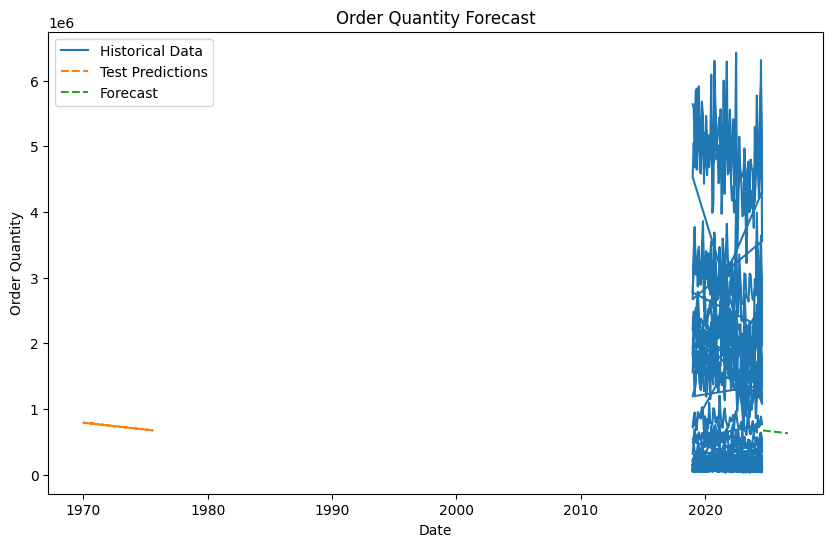

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data_grouped['ORDER_MONTH'], data_grouped['Total_Order_Qty'], label='Historical Data')
plt.plot(test_data['order_date'], test_data['predicted_order_quantity'], label='Test Predictions', linestyle='--')
plt.plot(forecast_data['order_date'], forecast_data['forecast_order_quantity'], label='Forecast', linestyle='--')
plt.title('Order Quantity Forecast')
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()

In [ ]:
for Fact_Customer_Orders_PRODUCT_ID, group in data_grouped:
    # Sort data by order date
    group.sort_index(inplace=True)
    
   # Split the data into training and testing sets(80% train, 20% test)
X = data_grouped[['date_numeric']]
y = data_grouped['Total_Order_Qty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
rse = np.sqrt(np.sum((y_train - y_train_pred) ** 2) / (len(y_train) - 2))
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)

# Forecast for the next 25 months (assuming 30 days per month)
future_dates = pd.date_range(start=data_grouped['ORDER_MONTH'].max(), periods=25, freq='M')
future_dates_numeric = (future_dates - data_grouped['ORDER_MONTH'].min()).days
future_X = pd.DataFrame(future_dates_numeric, columns=['date_numeric'])
future_predictions = model.predict(future_X)

    
    date_list = y_test_pred.index.to_list()

    
    #print(f"Order_date: {date_list}")    
    new_row = {
        'PRODUCT_ID': Fact_Customer_Orders_PRODUCT_ID,
        'ORDER_MONTH': date_list,
        'test_forecast_orders': y_test_pred,
        'rse': rse,
        'rmse': rmse,
        'r2_score': r2
    }




    df_new = pd.DataFrame(new_row)

    df_new.set_index('ORDER_MONTH')
    
    test_results=pd.concat([test_results,df_new],ignore_index=True)
    print(f'{test_results}')
    # Forecast future values
    forecast = model_fit.get_forecast(steps=25)#, steps=n_forecast)
    forecast_df = forecast.predicted_mean
    
    date_list2= forecast_df.index.to_list()
    
    new_row2 = {
        'product_id': product_id,
        'order_date': date_list2,
        'forecast_order_qty': forecast_df,
    }
    
    df_new2 = pd.DataFrame(new_row2)
    
    forecast_results=pd.concat([forecast_results,df_new2],ignore_index=True)

In [33]:
test_data

,order_date,actual_order_quantity,predicted_order_quantity
411,90,1536000,784808.673848
2673,639,194500,753253.524500
1364,120,310050,783084.348747
52,1581,4073600,699109.716330
1611,1430,94950,707788.819338
...,...,...,...
226,670,2416000,751471.721896
2541,762,52000,746183.791586
1951,1430,171500,707788.819338
1562,2008,209650,674566.822393


In [34]:
forecast_data

,order_date,forecast_order_quantity
0,2024-08-31,671060.694688
1,2024-09-30,669336.369587
2,2024-10-31,667554.566983
3,2024-11-30,665830.241882
4,2024-12-31,664048.439277
5,2025-01-31,662266.636673
6,2025-02-28,660657.266579
7,2025-03-31,658875.463975
8,2025-04-30,657151.138874
9,2025-05-31,655369.336269
